In [1]:
import numpy as np
import earthaccess
import rasterio as rio
from omnicloudmask import predict_from_array
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from rasterio.env import Env
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor

Use earthaccess to open an authenticated session with NASA Earthdata so we can stream HLS granules.

More info here:
https://www.earthdata.nasa.gov/data/earthdata-login

In [2]:
earthaccess.login(persist=True)

Request short-lived S3 credentials and configure GDAL so rasterio can stream the cloud-hosted GeoTIFFs directly.

In [ ]:
credentials = earthaccess.get_s3_credentials(daac="LPCLOUD")

env = Env(
    GDAL_HTTP_COOKIEFILE="~/cookies.txt",
    GDAL_HTTP_COOKIEJAR="~/cookies.txt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS="TIF",
    GDAL_HTTP_UNSAFESSL="YES",
    GDAL_HTTP_MAX_RETRY="10",
    GDAL_HTTP_RETRY_DELAY="0.5",
)


Define the area of interest as a bounding box (min lon, min lat, max lon, max lat).

In [4]:
bbox = (-122.09684570249401, 39.89193960036616, -122.03465069273044, 39.92326328372664)

Set the temporal window so the search only returns granules around the target date.

In [5]:
temporal = ("2021-05-22T00:00:00", "2021-05-23T23:59:59")

Search the Harmonized Landsat Sentinel collections (HLSL30 and HLSS30) that intersect the AOI and timeframe.

In [6]:
results = earthaccess.search_data(
    short_name=["HLSL30", "HLSS30"], bounding_box=bbox, temporal=temporal, count=1
)

Inspect the first search result to review metadata, browse imagery, and direct download links.

In [7]:
results[0]

Collection: {'EntryTitle': 'HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -121.96580014, 'Latitude': 39.65700237}, {'Longitude': -121.70642628, 'Latitude': 40.39605361}, {'Longitude': -121.70165934, 'Latitude': 40.64355721}, {'Longitude': -123.00023656, 'Latitude': 40.65085652}, {'Longitude': -123.00023316, 'Latitude': 39.66160696}, {'Longitude': -121.96580014, 'Latitude': 39.65700237}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-05-22T19:13:22.446Z', 'EndingDateTime': '2021-05-22T19:13:22.446Z'}}
Size(MB): 216.78629970550537
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B12.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B8A.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B08.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.SAA.tif']

Collect the asset download URLs exposed by each returned granule.

In [8]:
hls_results_urls = [granule.data_links() for granule in results]

Work with the first granule in the list for the rest of this example.

In [9]:
image_links = hls_results_urls[0]

Specify which HLS bands feed OmniCloudMask (RG + NIR) and which provide the RGB view.

In [10]:
OCM_bands = ["B04", "B03", "B8A"]
RGB_bands = ["B04", "B03", "B02"]

Stream each selected band into numpy arrays for inference and visualisation.

In [ ]:
def read_band(link: str) -> np.ndarray:
    with rio.open(link) as src:
        return src.read(1)


ocm_links = [
    link for link in image_links if any(band in link[8:] for band in OCM_bands)
]
rgb_links = [
    link for link in image_links if any(band in link[8:] for band in RGB_bands)
]

with env:
    with ThreadPoolExecutor(max_workers=3) as executor:
        ocm_band_list = list(
            executor.map(read_band, ocm_links),
        )
        rgb_input_list = list(
            executor.map(read_band, rgb_links),
        )

ocm_band_array = np.stack(ocm_band_list)
rgb_band_array = np.stack(rgb_input_list)


Normalise the RGB composite to display a true-colour image.

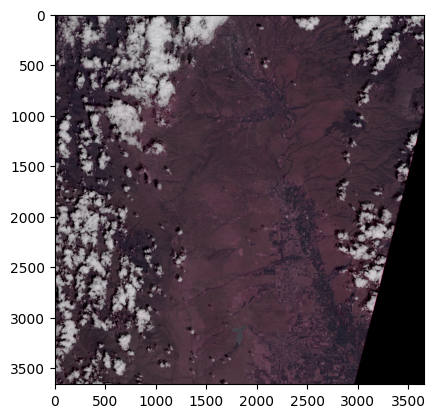

In [12]:
rgb_band_array = np.clip(rgb_band_array, 0, rgb_band_array.max())
RGB_array_norm = np.power(rgb_band_array.astype("float32"), 0.5)
RGB_array_norm = RGB_array_norm - np.min(RGB_array_norm)
RGB_array_norm = RGB_array_norm / np.max(RGB_array_norm)
RGB_array_norm = np.clip(RGB_array_norm, 0, 1).transpose(1, 2, 0)
plt.imshow(RGB_array_norm)

Run OmniCloudMask on the RG + NIR stack to predict clouds and shadows. Make sure to specify the nodata value -9999 for HLS data.

In [13]:
mask = predict_from_array(ocm_band_array, no_data_value=-9999)

Plot the RGB view alongside the predicted mask and overlay contours for context.

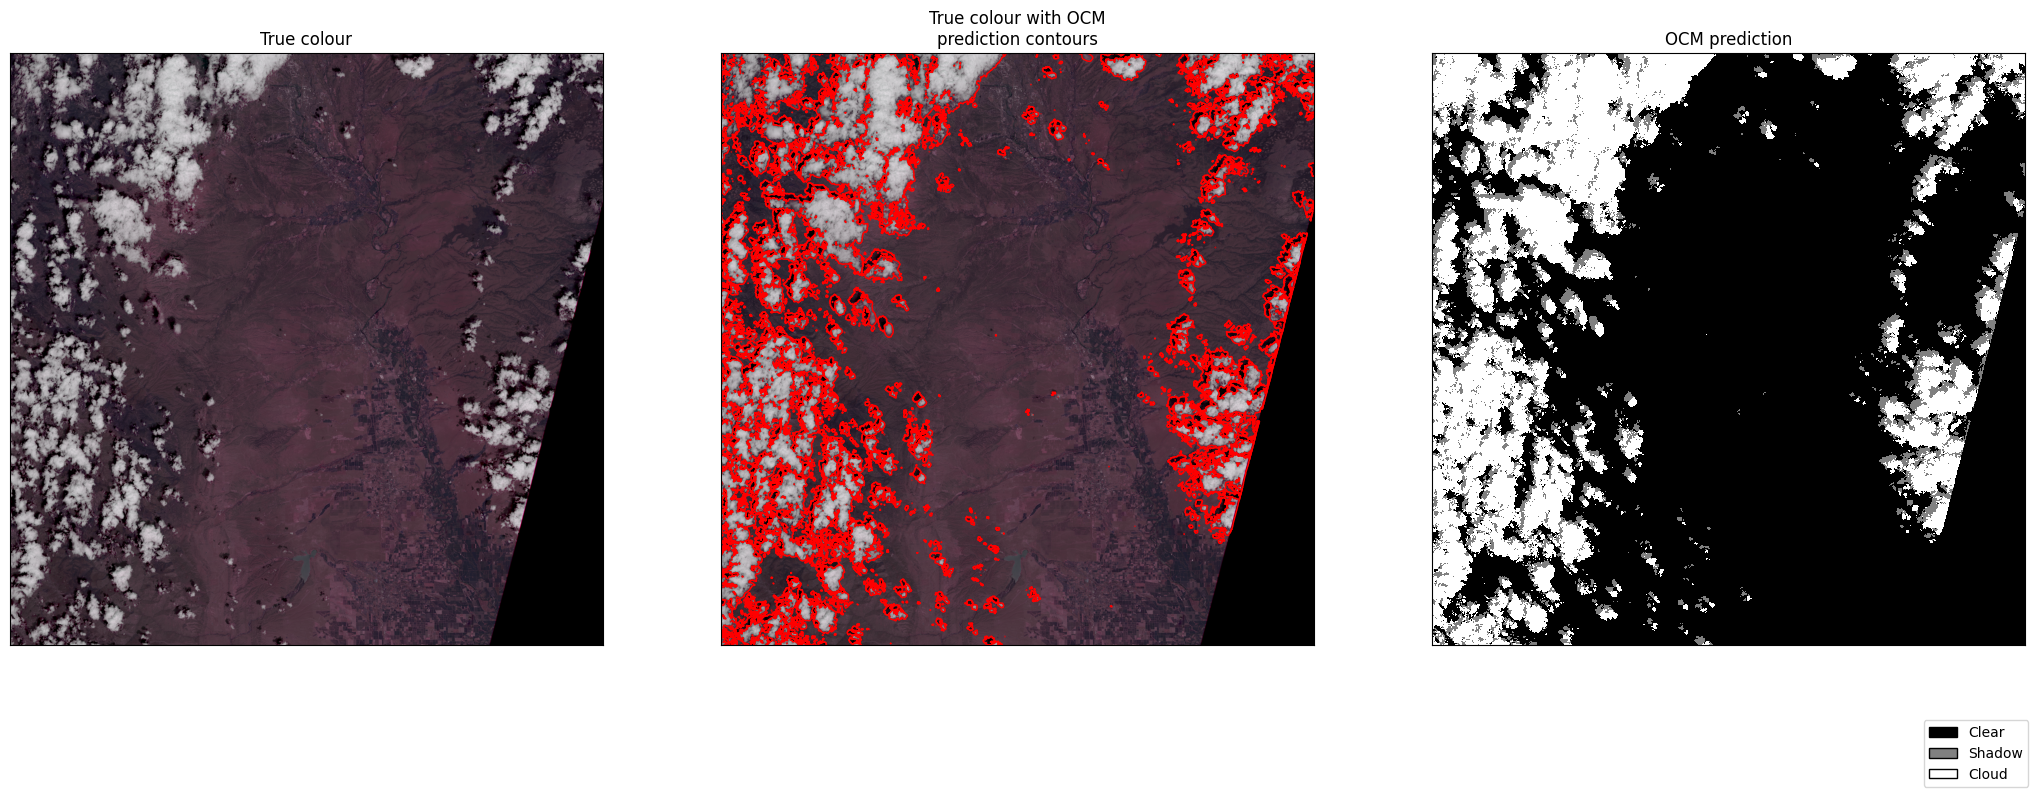

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(26, 10))
cmap = ListedColormap(["black", "white", "white", "grey"])

ax[0].imshow(RGB_array_norm)
ax[1].imshow(RGB_array_norm)
ax[1].contour(mask[0] > 0, colors="red", linewidths=1)
ax[1].contour(mask[0] == 3, colors="red", linewidths=1)
ax[2].imshow(mask[0], vmin=0, vmax=3, cmap=cmap, interpolation="nearest")

legend_labels = ["Clear", "Shadow", "Cloud"]
legend_colors = ["black", "grey", "white"]
patches = [
    mpatches.Patch(
        facecolor=legend_colors[i], edgecolor="black", label=legend_labels[i]
    )
    for i in range(3)
]
fig.legend(handles=patches, loc="lower right", bbox_to_anchor=(0.904, 0.05))

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

ax[0].set_title("True colour")
ax[1].set_title("True colour with OCM\nprediction contours")
ax[2].set_title("OCM prediction")

plt.show()
